## Теория вероятностей и математическая статистика

### Парная линейная регрессия

*Алла Тамбовцева*

Импортируем необходимые библиотеки, модули и функции:

* библиотеку `pandas` для обработки данных;
* модуль `api` из библиотеки `statsmodels` для запуска статистических функций;
* функцию `ols()` для оценки линейной модели.

In [3]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

Загрузим данные по ценам на квартиры в Москве (выгрузка с ЦИАН на апрель 2025 года):

In [4]:
flats = pd.read_csv("https://raw.githubusercontent.com/allatambov/StatCS25/refs/heads/main/flats_cian.csv")
flats.head()

,price,lprice,square,rooms,floor,mfloor,station,metro,ametro,dmetro,link
0,13281237,16.401863,54.3,2,2,9,метро Аннино,4 минуты пешком,1,4,https://www.cian.ru/sale/flat/316370232/
1,16000000,16.588099,53.2,2,15,17,метро Аннино,9 минут пешком,1,9,https://www.cian.ru/sale/flat/316762421/
2,36508182,17.413047,104.1,4,3,30,метро Аннино,4 минуты пешком,1,4,https://www.cian.ru/sale/flat/307195712/
3,12000000,16.300417,60.0,3,1,9,метро Аннино,6 минут на транспорте,0,6,https://www.cian.ru/sale/flat/314948168/
4,11500000,16.257858,50.4,2,2,17,метро Аннино,10 минут пешком,1,10,https://www.cian.ru/sale/flat/316513485/


Переменные в файле:

* `price`: цена квартиры (в рублях);
* `lprice`: цена квартиры (натуральный логарифм);
* `square`: площадь квартиры (в квадратных метрах);
* `rooms`: число комнат;
* `floor`: этаж;
* `mfloor`: общее число этажей в доме;
* `station`: станция метро;
* `metro`: доступность метро;
* `ametro`: доступность метро (1 – шаговая доступность, можно дойти пешком, 0 – иначе);
* `dmetro`: расстояние до метро (в минутах, пешком или на транспорте);
* `link`: ссылка на предложение на сайте.

Выведем описательные статистики для цены и площади квартиры:

In [5]:
print(flats[["price", "square"]].describe())

              price         square
count  1.031100e+05  103110.000000
mean   4.452741e+07      70.221368
std    9.641154e+07      44.607468
min    1.690000e+06       8.300000
25%    1.285000e+07      42.500000
50%    1.946846e+07      58.000000
75%    3.800000e+07      79.700000
max    2.862950e+09     979.500000


Кажется, что максимальное значение цены и площади неправдоподобны, однако можем убедиться, перейдя по ссылке, что такое предложение на ЦИАН есть, и там, действительно, дорогие огромные 5-комнатные апартаменты в Центральном административном округе (они еще и в ипотеку их предлагают):

In [6]:
flats[flats["price"] == flats["price"].max()]["link"]

55598    https://www.cian.ru/sale/flat/316200743/
72905    https://www.cian.ru/sale/flat/316200743/
72941    https://www.cian.ru/sale/flat/316200743/
Name: link, dtype: object

Как можно заметить, распределение цены квартиры `price` скошено вправо (среднее сильно больше медианы, большой разрыв между верхнем квартилем и максимумом), плюс, размах значений тоже большой. Убедимся в этом, построив гистограмму:

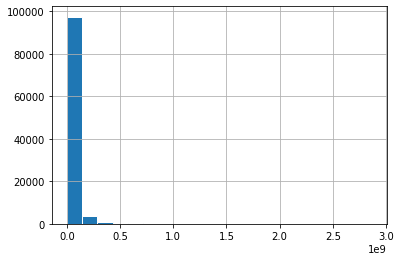

In [7]:
flats["price"].hist(edgecolor = "w", bins = 20);

Чтобы немного снизить скошенность распределения, в таких случаях интересующий показатель обычно логарифмируют, поэтому дальше мы будем работать с натуральным логарифмом цены квартиры `lprice`:

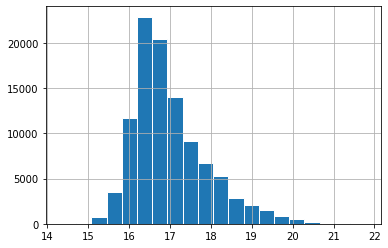

In [8]:
flats["lprice"].hist(edgecolor = "w", bins = 20);

Распределение этого показателя тоже скошено, но уже не так радикально, плюс, разброс значений за счет логарифмирования снизился. Проверим наличие нехарактерных значений (выбросов), построив ящик с усами:

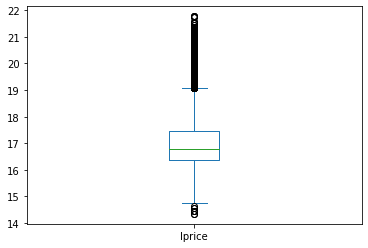

In [9]:
flats["lprice"].plot.box();

Проделаем то же для площади квартиры:

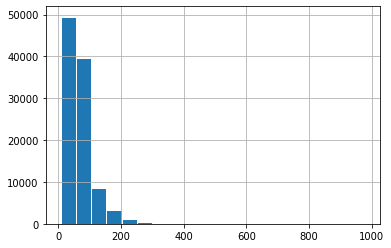

In [10]:
flats["square"].hist(edgecolor = "w", bins = 20);

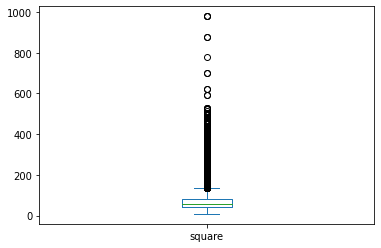

In [11]:
flats["square"].plot.box();

Выбросов много, давайте от них избавимся, оставив только квартиры с характерными значениями цены и площади:

In [12]:
# вычисляем квартили, межквартильный размах 
# и границы типичных значений для логарифма цены

p_Q1 = flats["lprice"].quantile(0.25)
p_Q3 = flats["lprice"].quantile(0.75)
P_iqr = p_Q3 - p_Q1
PL, PU = p_Q1 - 1.5 * P_iqr, p_Q3 + 1.5 * P_iqr

# вычисляем квартили, межквартильный размах 
# и границы типичных значений для площади

s_Q1 = flats["square"].quantile(0.25)
s_Q3 = flats["square"].quantile(0.75)
S_iqr = s_Q3 - s_Q1
SL, SU = s_Q1 - 1.5 * S_iqr, s_Q3 + 1.5 * S_iqr

# отфильтровываем строки, соответствующие значениям цены и площади
# в пределах границ типичных значений

flats_new = flats[(flats["lprice"] >= PL) & (flats["lprice"] <= PU) & 
                 (flats["square"] >= SL) & (flats["square"] <= SU)]

### Построение модели и таблица коэффициентов регрессии

Теперь все готово к работе. Построим модель линейной регрессии, где зависимой переменной является цена (логарифм цены `lprice`), а независимой – площадь квартиры `square`:

In [13]:
m01 = ols("lprice ~ square", data = flats_new).fit()

Выведем описание полученной модели, обученной на имеющихся данных:

In [14]:
m01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lprice   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                 1.147e+05
Date:                Thu, 22 May 2025   Prob (F-statistic):               0.00
Time:                        05:26:20   Log-Likelihood:                -63755.
No. Observations:               94808   AIC:                         1.275e+05
Df Residuals:                   94806   BIC:                         1.275e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.5090      0.004   3701.267      0.000      15.501      15.517
square         0.0219   6.47e-05    338.632      0.000       0.022       0.022
==============================================================================
Omnibus:                     3400.000   Durbin-Watson:                   0.787
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4492.614
Skew:                           0.391   Prob(JB):                         0.00
Kurtosis:                       3.725   Cond. No.                         176.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Приведем таблицы в «печатный» вид:

In [15]:
print(m01.summary())

                            OLS Regression Results                            
Dep. Variable:                 lprice   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                 1.147e+05
Date:                Thu, 22 May 2025   Prob (F-statistic):               0.00
Time:                        05:26:20   Log-Likelihood:                -63755.
No. Observations:               94808   AIC:                         1.275e+05
Df Residuals:                   94806   BIC:                         1.275e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.5090      0.004   3701.267      0.0

Сфокусируемся на второй части, это основная выдача для модели. В столбце `coef` указаны коэффициенты модели $\hat{b}_0$ и $\hat{b}_1$, это константа `Intercept` и угол наклона, коэффициент при `square`. Запишем уравнение модели:

$$
\widehat{lprice}_i = 15.51 + 0.02 \times square_i
$$

Получается, при увеличении площади квартиры на один квадратный метр логарифм ее цены, в среднем, увеличивается на 0.02. Константа в данном случае не интерпретируема, по определению это среднее ожидаемое значение цены, когда площадь квартиры равна 0. Таких квартир не бывает, константа отрицательна, это нормально. 

Интерпретировать коэффициенты в модели, где только одна переменная логарифмирована, не очень удобно, в данном случае, не совсем ясно, на сколько изменяется сама цена квартиры, если ее логарифм увеличивается. Возьмем экспоненту от коэффициента 0.02:

In [16]:
import math
print(math.exp(0.02))

1.0202013400267558


Можем заключить, что при увеличении площади квартиры на 1 квадратный метр, ее цена, в среднем, увеличивается в 1.02 раза, то есть, на 2%. Чтобы сразу получить изменения в процентах, можно было бы рассмотреть модель, где и зависимая, и независимая переменная логарифмированы, но не будем переключаться на такие модели, почитать про интерпретацию моделей с логарифмами переменных можно [здесь](https://library.virginia.edu/data/articles/interpreting-log-transformations-in-a-linear-model).

Во втором столбце `std err` сохранены значения стандартных ошибок коэффициентов $SE(\hat{b}_0)$ и $SE(\hat{b}_1)$, которые показывают, как, в среднем, значения оценок коэффициентов могут отличаться при запуске модели на разных выборках такого же размера. Как вычисляются эти ошибки (по крайней мере, для $\hat{b}_1$), обсуждали на лекции, к этому вопросу вернемся позже, когда посмотрим на ANOVA-таблицу.

В третьем столбце `t` указаны наблюдаемые значения t-статистики, вычисляемые для проверки гипотезы о коэффициентах (альтернативные гипотезы по умолчанию двусторонние):

$$
H_0: b_0 = 0 \text{ и } H_1: b_0 \ne 0
$$

$$
H_0: b_1= 0 \text{ и } H_1: b_1 \ne 0
$$

Так как константа модели нас обычно несильно интересует, сфокусируемся на второй паре гипотез. Содержательно, $H_0: b_1 = 0$ утверждает, что эффект независимой переменной на зависимую отсутствует (под эффектом здесь подразумевается направленная связь, не причинно-следственная). Если нулевая гипотеза отвергается, значение $b_1$ значимо отличается от 0, значение оценки коэффициента получилось на данных не нулевым не случайно, а потому, что связь между переменными действительно есть. Отсюда и принятие по умолчанию альтернативной гипотезы двусторонней – не так важен знак коэффициента, важно, отличен он от 0 или нет.

Вернемся к значениям `t`. Получаются эти значения следующим образом:

$$
t_{набл} = \frac{\hat{b}_0 - 0}{SE(\hat{b}_0)} = \frac{\hat{b}_0}{SE(\hat{b}_0)}
$$

$$
t_{набл} = \frac{\hat{b}_1 - 0}{SE(\hat{b}_1)} = \frac{\hat{b}_1}{SE(\hat{b}_1)}
$$

Если нулевая гипотеза верна, эти значения принадлежат распределению Стьюдента с $n-2$ степенями свободы, где $n$ – число наблюдений. Если бы мы строили критическую область, она бы имела следующий вид:

$$
(-\infty; -t_{(n-2, \frac{\alpha}{2})}] \cup [t_{(n-2, \frac{\alpha}{2})}; +\infty)
$$

Но Python не строит критическую область, а сразу вычисляет p-value, оно указано в столбце `P>|t|`. Итак, для коэффициента при `square`:

$$
\text{p-value} = \text{P}(|t| > |338.632|) = 0.000
$$

Приняв стандартный уровень значимости 5%, можем заключить, что площадь квартиры оказывает значимый эффект на ее цену, что неудивительно.

В последнем столбце выдачи указаны границы 95%-ных доверительных интервалов для коэффициентов регрессии. Если выборка достаточно большая, число наблюдений более 30, границы таких доверительных интервалов можно определять следующим образом (квантиль уровня 0.975 распределения Стьюдента с большим числом степеней свободы будет практически совпадать с квантилем того же уровня стандартного нормального распределения):

$$
\hat{b}_0 \pm 1.96 \times SE(\hat{b}_0)
$$

$$
\hat{b}_1 \pm 1.96 \times SE(\hat{b}_1)
$$

Если p-value уже посчитано, эти доверительные интервалы не сообщат нам ничего принципиально нового, но вообще эти доверительные интервалы можно использовать для проверки тех же гипотез о равенстве коэффициентов регрессии нулю. Если 95%-ный доверительный интервал включает значение 0, значение коэффициента может быть равным 0, а значит, гипотезу об отсутствии эффекта независимой переменной на зависимую отвергать не стоит. В данном случае из-за очень большого числа наблюдений (`No. Observations: 94808` перед выдачей) доверительные интервалы получились очень узкими, для коэффициента при `square` его границы при округлении до тысячных вообще совпадают.

Если какие-то фрагменты выдачи нужны отдельно, их можно вызвать через соответствующие атрибуты:

In [17]:
print(m01.params) # коэффициенты
print(m01.tvalues) # t-значения
print(m01.pvalues) # p-value

Intercept    15.508975
square        0.021894
dtype: float64
Intercept    3701.267394
square        338.631544
dtype: float64
Intercept    0.0
square       0.0
dtype: float64


Если нужны границы доверительных интервалов для коэффициентов, потребуется уже не атрибут, а метод – функция на объекте `m01`, которая на вход принимает уровень доверия:

In [18]:
# по умолчанию – 95%, но можем выставить другой

print(m01.conf_int()) 
print(m01.conf_int(0.9))
print(m01.conf_int(0.99))

                   0          1
Intercept  15.500762  15.517187
square      0.021767   0.022021
                   0          1
Intercept  15.508448  15.509501
square      0.021886   0.021902
                   0          1
Intercept  15.508922  15.509027
square      0.021893   0.021895


### ANOVA-таблица для модели и коэффициент детерминации $R^2$

Выведем ANOVA-таблицу для полученной модели:

In [19]:
print(sm.stats.anova_lm(m01))

               df        sum_sq       mean_sq              F  PR(>F)
square        1.0  25768.477988  25768.477988  114671.322594     0.0
Residual  94806.0  21304.422665      0.224716            NaN     NaN


Здесь в `sum_sq` – суммы квадратов:
    
* $\text{ESS}$ = 25768.47, *explained sum of squares*, объясненная сумма квадратов, часть дисперсии зависимой переменной, объясненная моделью, то есть линейной связью с независимой переменной;

* $\text{RSS}$ = 21304.42, *residual sum of squares*, сумма квадратов остатков модели, часть дисперсии зависимой переменной, которая моделью не объясняется. 

Вспомним формулы:

$$
\text{RSS} = \sum_i\hat{\varepsilon}^2 = \sum_i(y_i - \hat{y}_i)^2
$$

$$
\text{ESS} = \sum_i(\hat{y}_i - \bar{y})^2
$$

Общей суммы квадратов (*total sum of squares*) здесь нет, ее можно вычислить через сумму значений выше:

$$
\text{TSS} = \sum_i(y_i - \bar{y}_i)^2 = \text{ESS} + \text{RSS}
$$

Сумму столбца с квадратами считать не будем, запросим те же значения отдельно:

In [20]:
print("ESS =", m01.ess)
print("RSS = ", m01.ssr)
print("TSS =", m01.centered_tss)

ESS = 25768.477987735365
RSS =  21304.422665155704
TSS = 47072.90065289107


Для чего эти суммы квадратов нужны? Во-первых, для вычисления коэффициентов модели:

$$
SE(\hat{b}_1) = \sqrt{\frac{RSS / (n-2)}{\sum_i(x_i - \bar{x})^2}}
$$

Во-вторых, для оценки качества модели – вычисления коэффициента детерминации $R^2$:

$$
R^2 = \frac{\text{ESS}}{\text{TSS}}
$$

Как можно заметить, $R^2$ соответствует доли дисперсии зависимой переменной, которая объясняется построенной моделью. 

Вернемся к части выдачи перед таблицей с коэффициентами:


```
OLS Regression Results                            
==============================================================================
Dep. Variable:                 lprice   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                 1.147e+05
Date:                Thu, 22 May 2025   Prob (F-statistic):               0.00
Time:                        05:03:26   Log-Likelihood:                -63755.
No. Observations:               94808   AIC:                         1.275e+05
Df Residuals:                   94806   BIC:                         1.275e+05
Df Model:                           1                                         
Covariance Type:            nonrobust    
```


Здесь $R^2 = 0.547$, значит, примерно 55% изменчивости цен на квартиры в Москве можно объяснить различиями в их площади. Не очень высокий процент, но это ожидаемо – помимо площади есть много факторов, которые мы не учли в простой парной модели, но которые точно оказывают эффект на цену квартиры, например, ее удаленность от станции метро, от центра города и проч.

Извлечем значение $R^2$ из `m01` и проверим, что он вычисляется в Python по стандартной схеме, безо всяких корректировок:

In [21]:
print(m01.rsquared)
print(m01.ess / m01.centered_tss)

0.5474164037127962
0.5474164037127962


Скорректированная версия $R^2$ также существует, в основной выдаче это значение в указано `Adj. R-squared`. В случае парной модели этот показатель не очень интересен, актуален он будет во множественных моделях, то есть в моделях с несколькими независимыми переменными. Неформально, корректировка $R^2$ «штрафует» модель за большое количество независимых переменных, особенно, если наблюдений не очень много. Обычно при добавлении в модель новых независимых переменных, хоть как-то связанных с зависимой, совокупный разброс значений (общая вариация) увеличивается, что приводит к автоматическому увеличению $R^2$. Чтобы убедиться, что рост $R^2$ произошел не из-за увеличения числа переменных, а из-за увеличения объясняющей способности модели, обращаются к скорректированному коэффициенту детерминации. Подробнее об *adjusted $R^2$* можно почитать [здесь](https://en.wikipedia.org/wiki/Coefficient_of_determination).

Посмотрим на оставшиеся значения в ANOVA-таблице. 

```
               df        sum_sq       mean_sq              F  PR(>F)
square        1.0  25768.477988  25768.477988  114671.322594     0.0
Residual  94806.0  21304.422665      0.224716            NaN     NaN
```

Число степеней свободы `df` в строке с $\text{ESS}$ в парной модели всегда 1, число степеней свободы для остатков $\text{RSS}$ всегда $n-2$. Можно это проверить (и сравнить с `Df Residuals` и `Df Model` в основной выдаче над таблице с коэффициентами). Как и в обычной ANOVA, в столбце `mean_sq` хранятся усредненные суммы квадратов, суммы квадратов, поделенные на число степеней свободы из `df`. 

Последние два столбца в ANOVA-таблице для парной модели не очень актуальны, значение F-статистики ($F_{набл} = \text{Mean ESS} / \text{Mean RSS}$) вычисляется для проверки гипотезы о том, что все коэффициенты в модели не отличимы от нуля.

$$
H_0: b_1 = b_2 = \dots = b_k = 0 \text{ против } H_1: \exists j \text{ } b_j \ne 0
$$

Формулировка гипотез очень похожа на то, что мы видели в классической ANOVA для сравнения групп: все средние равны *vs* существует среднее, отличное от остальных. В случае парной модели у нас один интересующий нас коэффициент – $b_1$, поэтому результат проверки гипотезы выше будет совпадать с тем, что мы обсуждали ранее. В случае множественной модели отвержение такой $H_0$ будет означать то, что построенная модель, в принципе, нужна, раз не все коэффициенты не нулевые.

### Немного об остатках модели

Оценки коэффициентов, полученные с помощью метода наименьших квадратов, можно считать надежными, если выполняется условия Гаусса-Маркова:

* $\varepsilon_i$ – случайная величина, поведение ошибок модели случайно, они не подчиняются какой-то закономерности.
* $E(\varepsilon_i) = 0$, среднее ожидаемое значение ошибок модели равно 0, то есть модель может ошибаться в предсказании значения $y$ для $i$-того наблюдения как в большую, так и в меньшую сторону, но в теории, если мы будем повторять аналогичные исследования независимым образом много-много раз, средняя ошибка для этого наблюдения будет нулевой.
* $\varepsilon_i$, $\varepsilon_j$ независимы для любых наблюдений $i$ и $j$, то есть то, что модель ошибается в предсказании значения $y$ для одного наблюдения, никак не сказывается на ошибке предсказания для другого наблюдения. Нарушение этого условия называется *автокорреляцией*.
* $D(\varepsilon_i) = \sigma^2$, дисперсия ошибок постоянна и не зависит от значений независимой переменной, то есть модель ошибается примерно одинаково как при маленьких значениях независимой переменной, так и при больших. Это условие называется *гомоскедастичностью*, а его нарушение – *гетероскедастичностью*.
* $\varepsilon_i$ и $x_i$ независимы, это условие называется *экзогенностью*, а его нарушение – *эндогенностью*.

Также дополнительно выделяют условие $\varepsilon_i \sim N(0, \sigma^2)$, остатки модели имеют нормальное распределение со средним, равным нулю, и некоторой дисперсией. Оно не относится к условиям Гаусса-Маркова, но часто идет в связке с ними (условия Гаусса-Маркова+). При выполнении условий Гаусса-Маркова оценки коэффициентов линейной регрессии, полученные с помощью метода метода наименьших квадратов, считаются лучшими в классе линейных несмещенных оценок (*BLUE – best linear unbiased estimators*), а если в добавок выполняется условие нормальности остатков, то они считаются лучшими в классе несмещенных оценок вообще, 
не только линейных (*BUE – best unbiased estimators*).

Не все из условий выше обязательно проверяются; некоторые из них обеспечиваются по построению (равенство математического ожидания остатков нулю). Тем не менее, посмотрим, на распределение остатков модели:

count    94808.000
mean         0.000
std          0.474
min         -2.569
25%         -0.294
50%         -0.037
75%          0.272
max          2.131
dtype: float64


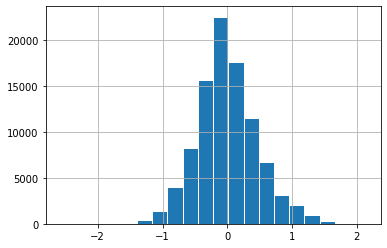

In [22]:
# атрибут .resid – остатки

residuals = m01.resid
print(residuals.describe().round(3))

residuals.hist(bins = 20, edgecolor = "w");

В целом, видно, что распределение остатков вполне симметрично, и центр распределения в 0. Формально проверять нормальность распределения остатков не будем, обратим внимание на то, что у распределения довольно острый пик, у «идеально» нормального распределения такого нет. Посмотрим на последнюю часть основной выдачи регрессии выше:

```
==============================================================================
Omnibus:                     3400.000   Durbin-Watson:                   0.787
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4492.614
Skew:                           0.391   Prob(JB):                         0.00
Kurtosis:                       3.725   Cond. No.                         176.
=============================================================================
```

`Skew` – коэффициент скошенности распределения, у симметричных распределений он равен 0. Здесь коэффициент равен 0.391, что говорит о небольшой скошенности вправо (если внимательно посмотреть на гистограмму, можно отметить, что правый «хвост» распределения длинее). `Kurtosis` – коэффициент эксцесса, остроты пика распределения. У нормального распределения этот коэффициент тоже равен 0. Здесь коэффициент более 3, что свидетельствует об очень остром пике распределения (можете построить график плотности с высокой детализацией при сглаживании и увидеть его более ярко).

Проверим «на глаз» выполнение еще некоторых условий – построим диаграмму рассеивания между независимой переменной и остатками:

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


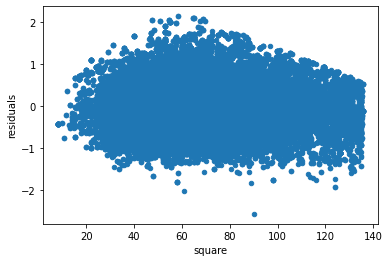

In [23]:
# чтобы не вызывать отдельно matplotlib, 
# просто добавим в датафрейм отдельный столбец с остатками

flats_new["residuals"] = residuals
flats_new.plot.scatter("square", "residuals");

Из-за большого числа точек диаграмма не очень наглядная, но приблизительное выполнение условий Гаусса-Маркова проверить она поможет. 

Для надежных выводов требуется, чтобы дисперсия остатков была постоянной, $D(\varepsilon_i) = \sigma^2$, то есть, не изменялась сильно при увеличении независимой переменной. Здесь это выполняется, разброс точек относительно прямой $\text{residuals} = 0$ примерно одинаков при разных значениях `square`. Это означает, что модель примерно одинаково ошибается при предсказании цен на квартиры как маленькой, так и большой площади. И для качества модели это хорошо! Если бы это условие не выполнялось, мы увидели бы на диаграмме рассеивания сходящуюся (дисперсия ошибок снижается при увеличении `square`) или расходящуюся (дисперсия ошибок увеличивается при увеличении `square`) «воронку» из точек.

Кроме того, точки образуют ровное «облако», которое «лежит» на боку, безо всякого наклона. А значит, линейной (и нелинейной тоже) связи между `square` и остатками нет. Условие независимости $\hat{\varepsilon}_i$ и $x_i$ выполняется.

Остальные условия трогать не будем, там более сложная история (и не всегда формальным тестам и p-value можно верить), небольшой спойлер для желающих – во фрагменте выдачи выше:

* `Durbin-Watson` – p-value для критерия Дарбина-Уотсона с гипотезой об отсутствии связи между остатками (автокорреляции); 
* `Jarque-Bera` и `Prob(JB)` – значение статистики и p-value для критерия Харке — Бера с гипотезой о нормальности распределения остатков.

### Предсказания с помощью модели

Чтобы не подставлять интересующие нас значения в уравнение модели для предсказания цены квартиры, можно воспользоваться методом `.predict()`. Если в аргументах ничего не указать, он просто предскажет значения зависимой переменной для всех наблюдений в данных:

In [24]:
# массив y^ для всех значений x
m01.predict()

array([16.69782694, 16.67374338, 17.78815545, ..., 16.38474064,
       16.64528099, 16.40444538])

Если мы хотим подставить в уравнение модели конкретные значения, необязательно из имеющихся данных (привет машинному обучению, где модель оцениваем на обучающей выборке, а проверяем на тестовой), их нужно подать на вход методу в виде словаря:

In [25]:
# одна квартира площадью 50
print(m01.predict(exog = {"square" : 50}))

# квартиры площадью 50 и 100
print(m01.predict(exog = {"square" : [50, 100]}))

0    16.603682
dtype: float64
0    16.603682
1    17.698389
dtype: float64


### О графиках и «доверительной трубке» вокруг регрессионной прямой

Как мы уже убедились выше, диаграммы рассеивания для большого числа точек выглядят не очень хорошо. Выберем квартиры в домах недалеко от кольцевых станций метро:

In [26]:
ring = ['метро Павелецкая', 'метро Курская', 'метро Октябрьская', 
'метро Добрынинская', 'метро Проспект Мира', 'метро Белорусская', 
'метро Краснопресненская', 'метро Киевская', 'метро Парк культуры',
'метро Таганская']

small = flats_new[flats_new["station"].isin(ring)]
print(small.shape) # 2787 квартир

(2787, 12)


Построим такую же модель, как и ранее, но на урезанных данных:

In [27]:
m02 = ols("lprice ~ square", data = small).fit()
print(m02.summary())

                            OLS Regression Results                            
Dep. Variable:                 lprice   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     4797.
Date:                Thu, 22 May 2025   Prob (F-statistic):               0.00
Time:                        05:26:30   Log-Likelihood:                -1464.6
No. Observations:                2787   AIC:                             2933.
Df Residuals:                    2785   BIC:                             2945.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.2844      0.021    778.022      0.0

В целом, результаты очень похожи на предыдущие для всех квартир в Москве.

Импортируем библиотеку `seaborn` – надстройку над базовым `matplotlib`, в которой много полезных статистических графиков, и построим диаграмму рассеивания с добавленной на нее регрессионной прямой:

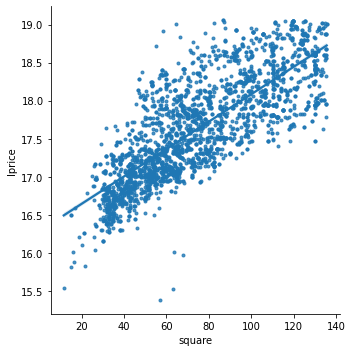

In [28]:
import seaborn as sns

# модель не нужна, lmplot() строит ее сама
# меняем тип маркера, чтобы точки были поменьше

sns.lmplot(data = small, 
           x = "square", 
           y = "lprice", 
           markers = '.');

Видно, что связь между площадью квартиры и логарифмированной ценой можно считать линейной и прямой. Линейная модель подходит. Однако функция `lmplot()` еще строит 95%-ную доверительную трубку для регрессионной прямой, отмечая границы, в которых с заданной уверенностью может лежать прямая при оценивании модели на иных данных. Где эта трубка здесь? Она есть, но ее не видно – из-за большого числа наблюдений доверительные интервалы для коэффициентов очень узкие. Попробуем разбить наблюдения на группы, причем осмысленно – по шаговой доступности метро `ametro`:

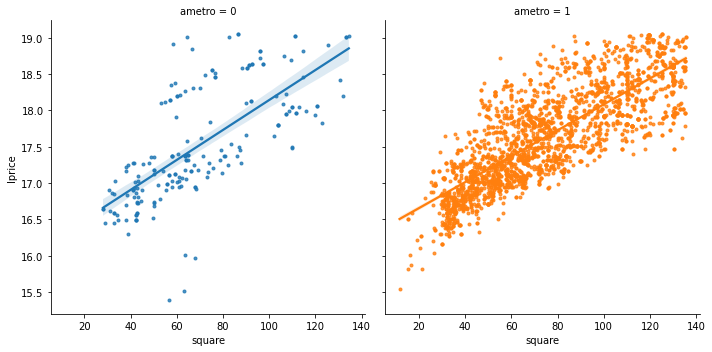

In [29]:
# hue – разный цвет точек и прямой для ametro = 0 и ametro = 1
# col – графики в разных столбцах для ametro = 0 и ametro = 1

sns.lmplot(data = small, 
           x = "square", 
           y = "lprice", 
           markers = '.', 
           col = "ametro", 
           hue = "ametro");

Вот теперь на графиках (по крайней мере, на левом) видна 95%-ная доверительная трубка, 95%-ный доверительный интервал для всей регрессионной прямой. И что интересно, такой график позволяет сравнить эффект площади квартиры на ее цену для домов с шаговой доступностью метро и без нее. Здесь наклон регрессионных прямых в обоих случаях примерно одинаковый, поэтому, скорее, всего, эффект площади одинаков. А что, если мы сравним эффект площади на цену в зависимости от количества комнат?

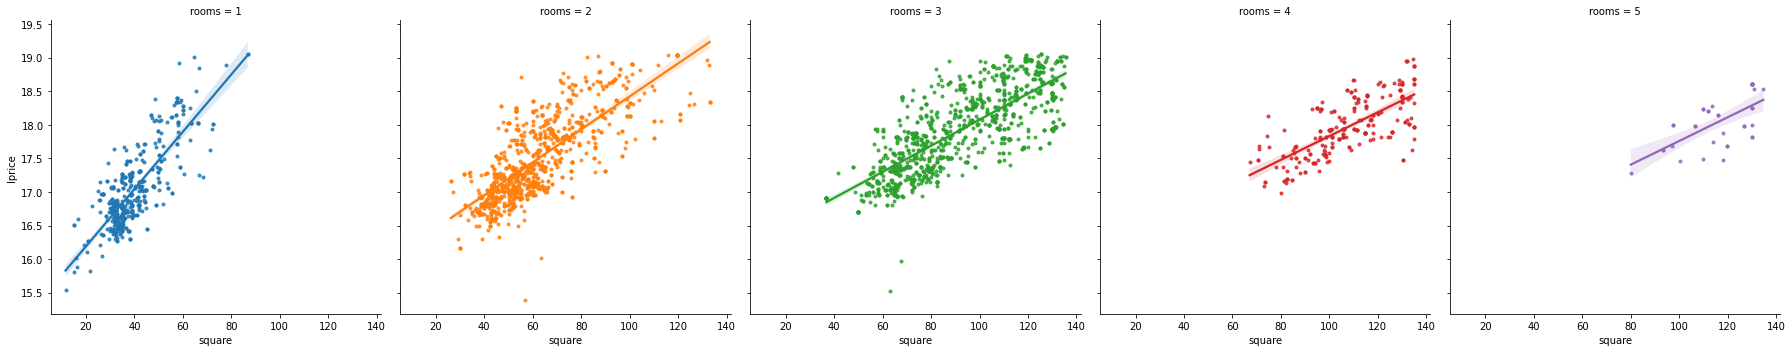

In [30]:
sns.lmplot(data = small, 
           x = "square", 
           y = "lprice", 
           markers = '.', 
           col = "rooms", 
           hue = "rooms");

Эффект площади квартиры на ее цену наиболее сильный в случае, если квартира состоит из одной комнаты, а вот, начиная с двух комнат, эффект площади уже слабее, но при этом для двух, трех, четырех и даже пяти комнат, он примерно одинаковый. Если подумать, логично: если люди покупают/продают однокомнатную квартиру, каждый метр очень важен, и это сказывается на цене. А если комнат больше, общая площадь тоже обычно больше, поэтому «прирост» площади в один квадратный метр уже не так значителен.

### Дополнительно: представление результатов

В статьях и отчётах выдачи с результатами регрессионного анализа обычно выглядят иначе, чем в Python. Установим библиотеку `stargazer` для экспорта результатов регрессионного анализа в красивом табличном виде:

In [ ]:
!pip install stargazer

Импортируем класс `Stargazer`:

In [31]:
from stargazer.stargazer import Stargazer

С помощью этого класса мы можем подготовить выдачу в табличном виде, поместив необходимые модели внутрь `Stargazer()` в виде списка:

In [32]:
stargazer = Stargazer([m01, m02])

Посмотрим, что получилось:

In [33]:
stargazer

Примечания. В шапке таблицы указано название зависимой переменной. Здесь в двух моделях одинаковая, индекс счастья. В самой таблице указаны оценки коэффициентов: константа (`Intercept`) и наклон – коэффициент при `square` в первой модели, коэффициент при `square` во второй модели. В скобках под значениями оценок коэффициентов по умолчанию указываются их стандартные ошибки, однако иногда там указывают наблюдаемое значение t-статистики. Чтобы не было разночтений, обычно об этом пишут в примечаниях к таблице, в строке с `Note`. И, как сообщает примечание в `Note`, звёздочки рядом с коэффициентами отражают их статистическую значимость:

* `*` – оценка коэффициента значима на 10% уровне значимости (90% уровне доверия), p-value менее 0.1;

* `**` – оценка коэффициента значима на 5% уровне значимости (95% уровне доверия), p-value менее 0.05;

* `***` – оценка коэффициента значима на 1% уровне значимости (99% уровне доверия), p-value менее 0.01.

Также в таблице указано число наблюдений `Observations` и показатели качества модели, о которых мы будем говорить позже.

Красивая выдача, каждая модель в отдельном столбце, как обычно и бывает в статьях. Как её выгрузить? Если вы работаете в LaTeX, все просто, метод `.render_latex()` вернёт код LaTeX для таблицы, который можно скопировать:

In [34]:
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{2}{c}{\textit{Dependent variable: lprice}} \
\cr \cline{2-3}
\\[-1.8ex] & (1) & (2) \\
\hline \\[-1.8ex]
 Intercept & 15.509$^{***}$ & 16.284$^{***}$ \\
& (0.004) & (0.021) \\
 square & 0.022$^{***}$ & 0.018$^{***}$ \\
& (0.000) & (0.000) \\
\hline \\[-1.8ex]
 Observations & 94808 & 2787 \\
 $R^2$ & 0.547 & 0.633 \\
 Adjusted $R^2$ & 0.547 & 0.633 \\
 Residual Std. Error & 0.474 (df=94806) & 0.409 (df=2785) \\
 F Statistic & 114671.323$^{***}$ (df=1; 94806) & 4796.770$^{***}$ (df=1; 2785) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{2}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


Если вы работаете в Word, можно вернуть код для таблицы в виде кода HTML:

In [35]:
print(stargazer.render_html())

<table style="text-align:center"><tr><td colspan="3" style="border-bottom: 1px solid black"></td></tr>
<tr><td style="text-align:left"></td><td colspan="2"><em>Dependent variable: lprice</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td></tr>
<tr><td colspan="3" style="border-bottom: 1px solid black"></td></tr>

<tr><td style="text-align:left">Intercept</td><td>15.509<sup>***</sup></td><td>16.284<sup>***</sup></td></tr>
<tr><td style="text-align:left"></td><td>(0.004)</td><td>(0.021)</td></tr>
<tr><td style="text-align:left">square</td><td>0.022<sup>***</sup></td><td>0.018<sup>***</sup></td></tr>
<tr><td style="text-align:left"></td><td>(0.000)</td><td>(0.000)</td></tr>

<td colspan="3" style="border-bottom: 1px solid black"></td></tr>
<tr><td style="text-align: left">Observations</td><td>94808</td><td>2787</td></tr><tr><td style="text-align: left">R<sup>2</sup></td><td>0.547</td><td>0.633</td></tr><tr><td style="text-align:

Далее, в блокноте или прямо в Jupyter (*New – Text File*) можно создать новый текстовый файл с расширением `.htm` и скопировать туда код для таблицы. Это специфический формат, файл и как страницу HTML в браузере можно открыть, и как текст в редакторе в обработанном виде. Если открыть этот файл в браузере, мы увидим готовую свёрстанную таблицу, если открыть с помощью Word или аналогичного текстового редактора, мы увидим таблицу, которую можно редактировать.

При необходимости (а часто такая необходимость возникает, хотя бы для того, чтобы вывести значения с точностью до второго знака после точки) можно скорректировать настройки выгружаемых таблиц. Почитать про это можно в тьюториале из официальной [документации](https://pypi.org/project/stargazer/).